## Erik Bayerlein - 537606

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

### Algorithms

#### Auxiliary Algorithms

In [1620]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

In [1621]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def softmax_derivative(x):
    return x * (1 - x)

In [1622]:
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse_loss(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

### MLP

In [1623]:
class MLP(RegressorMixin, BaseEstimator):
    def __init__(self, max_iter: int = 500, activation: str = 'sigmoid', 
                 hidden_layers: list = [3], learning_rate: float = 0.1, 
                 momentum: float = 0.9, batch_size: int = 32, task: str = 'regression', n_classes: int = 2):
        match activation:
            case 'sigmoid':
                self.activation = sigmoid
                self.activation_deriv = sigmoid_derivative
            case 'softmax':
                self.activation = softmax
                self.activation_deriv = softmax_derivative
            case _:
                print('Invalid activation function')
                return
        self.max_iter = max_iter
        self.n_classes = n_classes
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.batch_size = batch_size
        self.task = task
        self.weights = []
        self.biases = []
        self.v_weights = []
        self.v_biases = []

    def __initialize_weights(self, n_features: int, n_outputs: int):
        layers = [n_features] + self.hidden_layers + [n_outputs]
        for i in range(len(layers) - 1):
            weight = np.random.randn(layers[i], layers[i + 1]) * 0.01
            bias = np.zeros((1, layers[i + 1]))
            
            v_weight = np.zeros_like(weight)
            v_bias = np.zeros_like(bias)
            
            self.weights.append(weight)
            self.biases.append(bias)
            self.v_weights.append(v_weight)
            self.v_biases.append(v_bias)

    def __forward_pass(self, X: np.ndarray):
        activations = [X]
        z_values = np.asarray([])

        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]

            if i < len(self.weights) - 1:
                a = self.activation(z)
            else:
                a = z  # linear output for regression

            activations.append(a)
            z_values = np.append(z_values, z)

        return activations, z_values

    def __backward_pass(self, X: np.ndarray, Y: np.ndarray, activations: list):
        m = X.shape[0]
        output_error = activations[-1] - Y
        errors = [output_error]

        # calculate errors for hidden layers
        for i in range(len(self.weights) - 2, -1, -1):
            derivative = self.activation_deriv(activations[i + 1])
            error = np.dot(errors[-1], self.weights[i + 1].T) * derivative
            errors.append(error)
        
        errors.reverse()
        
        # update weights and biases with momentum
        for i in range(len(self.weights)):
            dW = np.dot(activations[i].T, errors[i])
            db = np.mean(errors[i], axis=0, keepdims=True)
            
            self.v_weights[i] = self.momentum * self.v_weights[i] + (1 - self.momentum) * dW
            self.v_biases[i] = self.momentum * self.v_biases[i] + (1 - self.momentum) * db

            self.weights[i] -= self.learning_rate * self.v_weights[i]
            self.biases[i] -= self.learning_rate * self.v_biases[i]

    def _one_hot_encode(self, y, n_classes):
        one_hot = np.zeros((len(y), n_classes))
        one_hot[np.arange(len(y)), y.astype(int)] = 1
        return one_hot

    def fit(self, X_train: np.ndarray, Y_train: np.ndarray, X_val = None, Y_val = None):
        self.X_train = X_train
        
        if self.task == 'classification' and self.n_classes > 2:
            self.Y_train = self._one_hot_encode(Y_train, self.n_classes)
        else:
            self.Y_train = Y_train.reshape(-1, 1) if Y_train.ndim == 1 else Y_train

        self.X_val = X_val
        self.Y_val = Y_val
        
        n_features = self.X_train.shape[1]
        n_outputs = self.Y_train.shape[1]

        self.__initialize_weights(n_features, n_outputs)
        
        self.loss_history_mse = []
        self.loss_history_rmse = []
        self.loss_history_mae = []

        self.val_loss_history_mse = []
        self.val_loss_history_rmse = []
        self.val_loss_history_mae = []

        self.train_accuracy = []
        self.val_accuracy = []
        
        for epoch in range(self.max_iter):
            permutation = np.random.permutation(self.X_train.shape[0])
            X_train_shuffled = self.X_train[permutation]
            Y_train_shuffled = self.Y_train[permutation]
            
            # train on each batch
            for i in range(0, X_train_shuffled.shape[0], self.batch_size):
                X_batch = X_train_shuffled[i:i + self.batch_size]
                Y_batch = Y_train_shuffled[i:i + self.batch_size]

                activations, _ = self.__forward_pass(X_batch)
                self.__backward_pass(activations=activations, X=X_batch, Y=Y_batch)
            
            train_activations, _ = self.__forward_pass(self.X_train)

            train_loss_mse = mse_loss(self.Y_train, train_activations[-1])
            train_loss_rmse = rmse(self.Y_train, train_activations[-1])
            train_loss_mae = mae(self.Y_train, train_activations[-1])

            self.loss_history_mse.append(train_loss_mse)
            self.loss_history_rmse.append(train_loss_rmse)
            self.loss_history_mae.append(train_loss_mae)
            
            if self.task == 'classification':
                if self.n_classes > 2:
                    train_pred_class = np.argmax(train_activations[-1], axis=1)
                    train_labels = np.argmax(self.Y_train, axis=1)
                else:
                    train_pred_class = (train_activations[-1] > 0.5).astype(int)
                    train_labels = self.Y_train.reshape(-1)
                train_acc = accuracy_score(train_labels, train_pred_class)
                self.train_accuracy.append(train_acc)
            
            # validation loss
            if self.X_val is not None and self.Y_val is not None:
                val_pred = self.predict(self.X_val)

                if self.task == 'classification' and self.n_classes > 2:
                    Y_val_encoded = self._one_hot_encode(self.Y_val, self.n_classes)
                    val_loss_mse = mse_loss(Y_val_encoded, val_pred)
                else:
                    val_loss_mse = mse_loss(self.Y_val.reshape(-1, 1), val_pred)
                
                val_loss_rmse = np.sqrt(val_loss_mse)
                val_loss_mae = mae(self.Y_val.reshape(-1, 1), val_pred)

                self.val_loss_history_mse.append(val_loss_mse)
                self.val_loss_history_rmse.append(val_loss_rmse)
                self.val_loss_history_mae.append(val_loss_mae)
                
                if self.task == 'classification':
                    if self.n_classes > 2:
                        val_pred_class = np.argmax(val_pred, axis=1)
                        val_labels = self.Y_val.reshape(-1)
                    else:
                        val_pred_class = (val_pred > 0.5).astype(int)
                        val_labels = self.Y_val.reshape(-1)
                    val_acc = accuracy_score(val_labels, val_pred_class)
                    self.val_accuracy.append(val_acc)
            
            if (epoch + 1) % 50 == 0:
                progress = int(50 * (epoch + 1) / self.max_iter)
                bar = "█" * progress + "░" * (50 - progress)
                percentage = 100 * (epoch + 1) / self.max_iter
                if self.X_val is not None:
                    print(f"\r[{bar}] {percentage:.1f}%", end="")
                    if self.task == 'classification':
                        print(f' | Epoch {epoch + 1}/{self.max_iter}, Train Acc: {self.train_accuracy[-1]:.4f}, Val Acc: {self.val_accuracy[-1]:.4f}')
                    else:
                        print(f' | Epoch {epoch + 1}/{self.max_iter}, Train: {train_loss_mse:.6f}, Val: {self.val_loss_history_mse[-1]:.6f}')

    def predict(self, X_test: np.ndarray):
        activations, _ = self.__forward_pass(X_test)
        return activations[-1]

-----------------------------------------------------

## Q1

In [1624]:
data = pd.read_csv('../../datasets/concrete.csv')

train_val, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=0)
train, val = train_test_split(train_val, test_size=0.25, shuffle=True, random_state=0)

In [1625]:
X_train = train.iloc[:, :-1].values
Y_train = train.iloc[:, -1].values

X_val = val.iloc[:, :-1].values
Y_val = val.iloc[:, -1].values

X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

In [1626]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [1627]:
mlp = MLP(
    max_iter=1000, 
    activation='sigmoid', 
    hidden_layers=[50], 
    learning_rate=0.001,
    momentum=0.9,
    batch_size=32
)

In [1628]:
mlp.fit(X_train, Y_train, X_val, Y_val)

[██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 5.0% | Epoch 50/1000, Train: 55.805470, Val: 55.082620
[█████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 10.0% | Epoch 100/1000, Train: 46.010609, Val: 48.281170
[███████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 15.0% | Epoch 150/1000, Train: 38.662889, Val: 43.348360
[██████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 20.0% | Epoch 200/1000, Train: 31.986272, Val: 39.056626
[████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 25.0% | Epoch 250/1000, Train: 27.594093, Val: 37.114528
[███████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 30.0% | Epoch 300/1000, Train: 23.876098, Val: 34.187882
[█████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 35.0% | Epoch 350/1000, Train: 21.825101, Val: 33.564250
[████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 40.0% | Epoch 400/1000, Train: 19.305880, Val: 34.581102
[██████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 45.0% | Epoch 450/1000, Train: 17.420397, Val: 32.900784
[███████████

In [1629]:
train_predictions = mlp.predict(X_train)
val_predictions = mlp.predict(X_val)
test_predictions = mlp.predict(X_test)

In [1630]:
final_train_loss = mse_loss(Y_train, train_predictions.reshape(-1))
final_val_loss = mse_loss(Y_val, val_predictions.reshape(-1))
final_test_loss = mse_loss(y_test, test_predictions.reshape(-1))

print("\n" + "="*50)
print("FINAL RESULTS:")
print("="*50)
print(f"Final Train Loss: {final_train_loss:.6f}")
print(f"Final Validation Loss: {final_val_loss:.6f}")
print(f"Final Test Loss: {final_test_loss:.6f}")


FINAL RESULTS:
Final Train Loss: 8.393758
Final Validation Loss: 28.248336
Final Test Loss: 39.104323


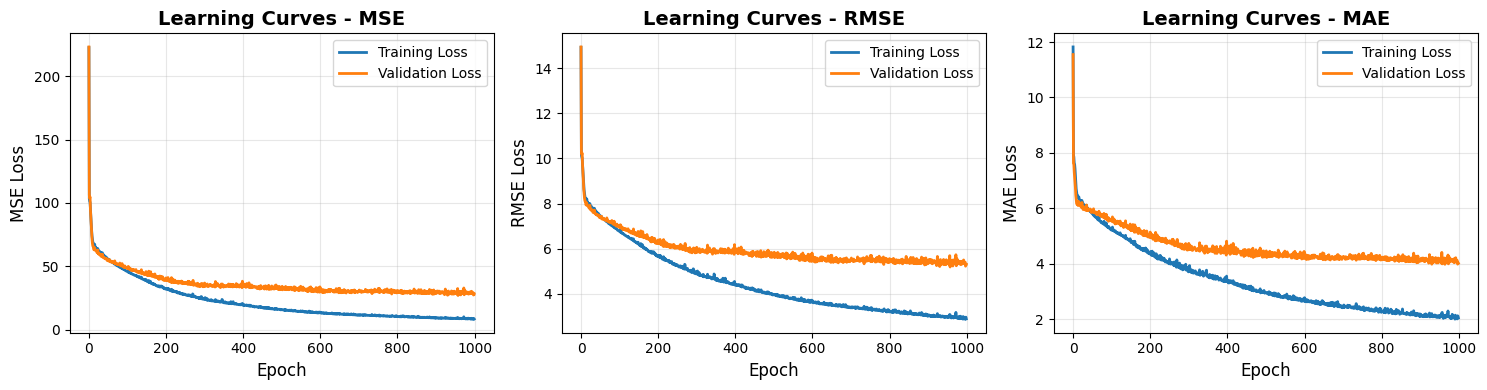

In [1631]:
plt.figure(figsize=(15, 4))

# MSE plot
plt.subplot(1, 3, 1)
plt.plot(mlp.loss_history_mse, label='Training Loss', linewidth=2)
plt.plot(mlp.val_loss_history_mse, label='Validation Loss', linewidth=2)
plt.title('Learning Curves - MSE', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# RMSE plot
plt.subplot(1, 3, 2)
plt.plot(mlp.loss_history_rmse, label='Training Loss', linewidth=2)
plt.plot(mlp.val_loss_history_rmse, label='Validation Loss', linewidth=2)
plt.title('Learning Curves - RMSE', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('RMSE Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# MAE plot
plt.subplot(1, 3, 3)
plt.plot(mlp.loss_history_mae, label='Training Loss', linewidth=2)
plt.plot(mlp.val_loss_history_mae, label='Validation Loss', linewidth=2)
plt.title('Learning Curves - MAE', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [1632]:
rmse_train = rmse(Y_train, train_predictions)
rmse_val = rmse(Y_val, val_predictions)
rmse_test = rmse(y_test, test_predictions)

mae_train = mae(Y_train, train_predictions)
mae_val = mae(Y_val, val_predictions)
mae_test = mae(y_test, test_predictions)

print("\nDETAILED METRICS:")
print("-"*30)
print(f"Train - MSE: {final_train_loss:.4f}, RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}")
print(f"Val   - MSE: {final_val_loss:.4f}, RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")
print(f"Test  - MSE: {final_test_loss:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}")


DETAILED METRICS:
------------------------------
Train - MSE: 8.3938, RMSE: 23.8348, MAE: 19.1397
Val   - MSE: 28.2483, RMSE: 23.3665, MAE: 18.5766
Test  - MSE: 39.1043, RMSE: 22.0134, MAE: 17.5315


## Q2

In [1633]:
data = pd.read_csv('../../datasets/vowel.csv')

train_val, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=0)
train, val = train_test_split(train_val, test_size=0.25, shuffle=True, random_state=0)

In [1634]:
X_train = train.iloc[:, :-1].values
Y_train = train.iloc[:, -1].values

X_val = val.iloc[:, :-1].values
Y_val = val.iloc[:, -1].values

X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

In [1635]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [1636]:
n_classes = len(np.unique(Y_train))

mlp = MLP(
    max_iter=1000, 
    activation='softmax', 
    hidden_layers=[50], 
    learning_rate=0.01,
    momentum=0.9,
    batch_size=32,
    n_classes=n_classes,
    task='classification'
)

In [1637]:
mlp.fit(X_train, Y_train, X_val, Y_val)

[██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 5.0% | Epoch 50/1000, Train Acc: 0.1956, Val Acc: 0.1364
[█████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 10.0% | Epoch 100/1000, Train Acc: 0.3744, Val Acc: 0.3889
[███████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 15.0% | Epoch 150/1000, Train Acc: 0.4755, Val Acc: 0.4596
[██████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 20.0% | Epoch 200/1000, Train Acc: 0.5801, Val Acc: 0.5707
[████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 25.0% | Epoch 250/1000, Train Acc: 0.6425, Val Acc: 0.5859
[███████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 30.0% | Epoch 300/1000, Train Acc: 0.6644, Val Acc: 0.6162
[█████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 35.0% | Epoch 350/1000, Train Acc: 0.6712, Val Acc: 0.6364
[████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 40.0% | Epoch 400/1000, Train Acc: 0.7099, Val Acc: 0.6717
[██████████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 45.0% | Epoch 450/1000, Train Acc: 0.7656, Val Acc: 0

In [1638]:
train_predictions = mlp.predict(X_train)
val_predictions = mlp.predict(X_val)
test_predictions = mlp.predict(X_test)

train_pred_class = np.argmax(train_predictions, axis=1)
val_pred_class = np.argmax(val_predictions, axis=1)
test_pred_class = np.argmax(test_predictions, axis=1)

In [1639]:
train_accuracy = accuracy_score(Y_train, train_pred_class)
val_accuracy = accuracy_score(Y_val, val_pred_class)
test_accuracy = accuracy_score(y_test, test_pred_class)

print("\n" + "="*60)
print("CLASSIFICATION RESULTS - Q2 (Vowel Dataset)")
print("="*60)
print(f"Training Accuracy:   {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy:       {test_accuracy:.4f}")


CLASSIFICATION RESULTS - Q2 (Vowel Dataset)
Training Accuracy:   0.8769
Validation Accuracy: 0.7273
Test Accuracy:       0.7727


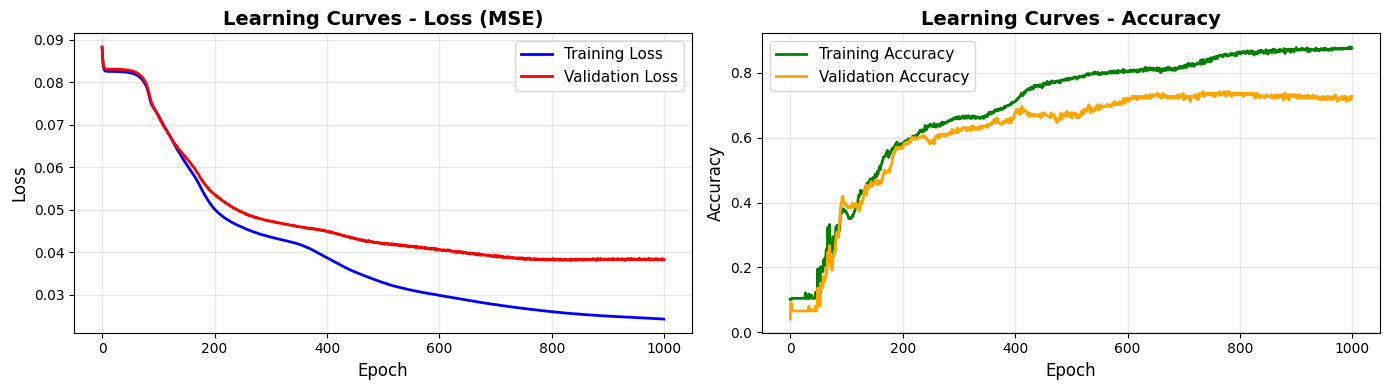

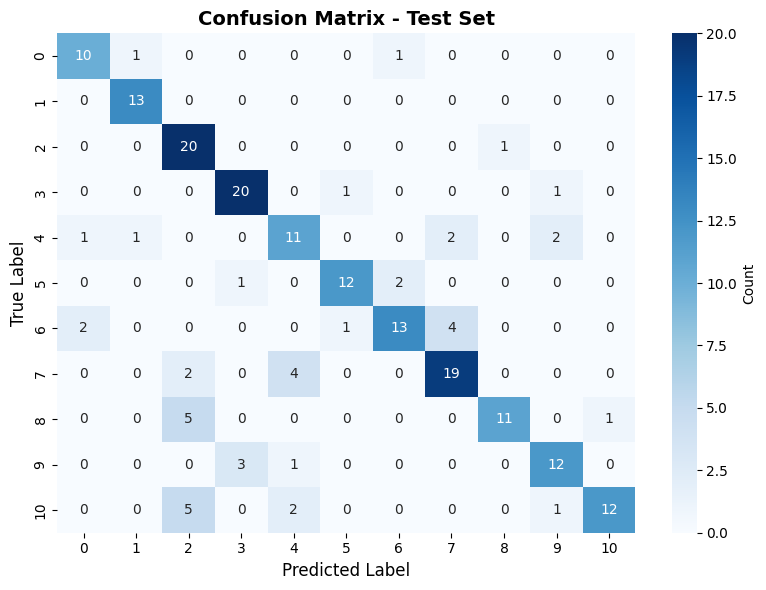

In [1640]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# loss curves
axes[0].plot(mlp.loss_history_mse, label='Training Loss', linewidth=2, color='blue')
axes[0].plot(mlp.val_loss_history_mse, label='Validation Loss', linewidth=2, color='red')
axes[0].set_title('Learning Curves - Loss (MSE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# accuracy curves
axes[1].plot(mlp.train_accuracy, label='Training Accuracy', linewidth=2, color='green')
axes[1].plot(mlp.val_accuracy, label='Validation Accuracy', linewidth=2, color='orange')
axes[1].set_title('Learning Curves - Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# confusion matrix
cm = confusion_matrix(y_test, test_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()